In [1]:
!pip install pyradox

  Created wheel for pyradox: filename=pyradox-0.18.10-py3-none-any.whl size=52990 sha256=11e1ae3f9e30df4362dcf670338cc7a858eee615630adac42613f555f13657d0
  Stored in directory: /root/.cache/pip/wheels/95/3e/72/768a49948cc49cfd01c6994bc5565e1dd892fb31458f7e264e
Successfully built pyradox


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
import cv2
from pyradox import convnets

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])

del x_train, y_train, x_test, y_test
x_all.shape, y_all.shape

11493376/11490434 [==============================] - 0s 0us/step


((70000, 28, 28), (70000,))

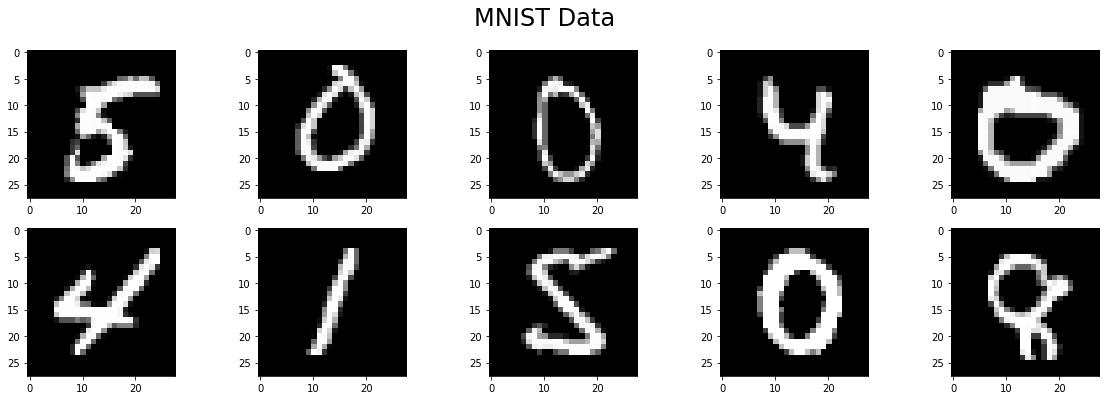

In [4]:
np.random.seed(19)

fig, ax = plt.subplots(2, 5, figsize=(20, 6))
for i, idx in enumerate(np.random.choice(np.arange(70000), size=10)):
    ax[i//5][i%5].imshow(x_all[idx], cmap='gray')
fig.suptitle('MNIST Data', fontsize=24);

# Data Preparation

* Paste images of handwritten digits on 64x64 blank images after resizing randomly 
* Color invert
* Rescale the data from 0-255 to 0-1

In [5]:
IMG_SIZE = 64
np.random.seed(19)


X = np.zeros((70000, IMG_SIZE, IMG_SIZE))
Y = np.zeros((70000, 4))
for i, x in tqdm(enumerate(x_all)):
    resize = np.random.uniform(0.5,1.5)
    im_size = int(resize*28)
    y_min = np.random.randint(0, (IMG_SIZE-im_size)-2)
    x_min = np.random.randint(0, (IMG_SIZE-im_size)-2)
        
    X[i, y_min:y_min+im_size, x_min:x_min+im_size] = cv2.resize(x, (im_size, im_size))
    Y[i] = [x_min, y_min, x_min+im_size, y_min+im_size]
    
X = np.expand_dims(1 - X/255.0, axis=-1)
Y = [tf.keras.utils.to_categorical(y_all), Y/IMG_SIZE]

0it [00:00, ?it/s]

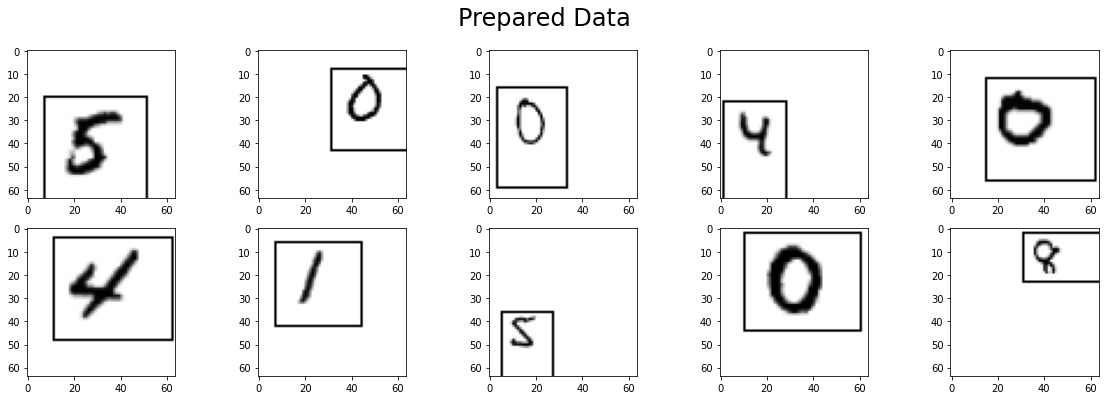

In [6]:
np.random.seed(19)

fig, ax = plt.subplots(2, 5, figsize=(20, 6))
for i, idx in enumerate(np.random.choice(np.arange(70000), size=10)):
    ax[i//5][i%5].imshow(cv2.rectangle(np.squeeze(X[idx].copy()), Y[1][idx]*IMG_SIZE, 0), cmap='gray')
fig.suptitle('Prepared Data', fontsize=24);

# Modelling
using Mobile Net V2

In [7]:
inp = tf.keras.Input(shape=(64, 64, 1))
x = tf.keras.layers.Convolution2D(3, 3, padding='same')(inp)
# x = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')(x)
x = convnets.MobileNetV3('small')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
y_clf = tf.keras.layers.Dense(10, activation='softmax', name='clf')(x)
y_reg = tf.keras.layers.Dense(4, name='reg')(x)

model = tf.keras.models.Model(inputs=inp, outputs=[y_clf, y_reg])
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
    loss={'clf': 'categorical_crossentropy','reg': 'mean_squared_error'}, 
    metrics={'clf': 'acc', 'reg': 'mean_absolute_error'}
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 3)    30          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_1[0][0]                   
______________________________________________________________________________________________

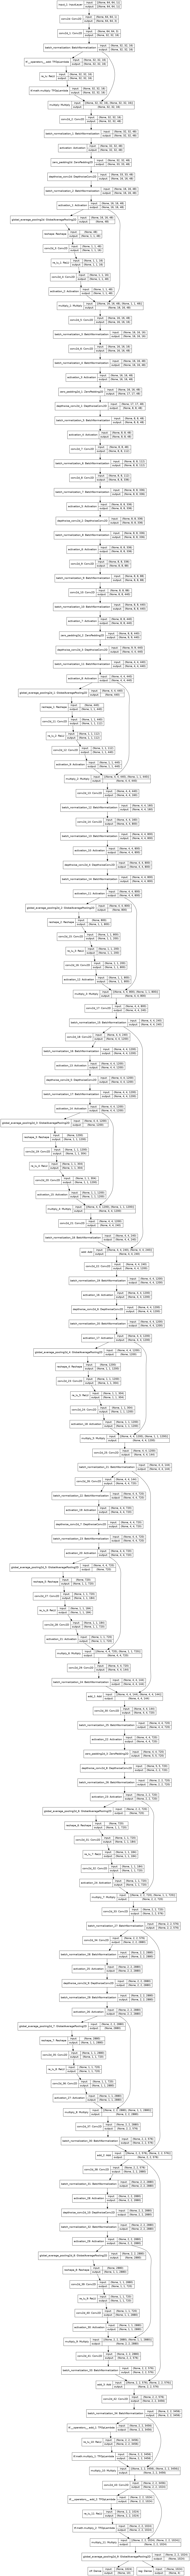

In [8]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True, verbose=1)
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, min_lr=1e-7, verbose=1)

history = model.fit(X, Y, epochs=1000, validation_split=0.1, callbacks=[es, rlp])

Epoch 1/1000
1969/1969 [==============================] - 88s 41ms/step - loss: 1.8523 - clf_loss: 1.8189 - reg_loss: 0.0334 - clf_acc: 0.3384 - reg_mean_absolute_error: 0.1171 - val_loss: 2.4997 - val_clf_loss: 2.3099 - val_reg_loss: 0.1898 - val_clf_acc: 0.0983 - val_reg_mean_absolute_error: 0.3667
Epoch 2/1000
1969/1969 [==============================] - 78s 40ms/step - loss: 0.4995 - clf_loss: 0.4945 - reg_loss: 0.0050 - clf_acc: 0.8301 - reg_mean_absolute_error: 0.0552 - val_loss: 2.4345 - val_clf_loss: 2.3439 - val_reg_loss: 0.0906 - val_clf_acc: 0.0983 - val_reg_mean_absolute_error: 0.2470
Epoch 3/1000
1969/1969 [==============================] - 78s 40ms/step - loss: 0.2830 - clf_loss: 0.2783 - reg_loss: 0.0047 - clf_acc: 0.9067 - reg_mean_absolute_error: 0.0533 - val_loss: 2.2215 - val_clf_loss: 2.1839 - val_reg_loss: 0.0376 - val_clf_acc: 0.2273 - val_reg_mean_absolute_error: 0.1614
Epoch 4/1000
1969/1969 [==============================] - 78s 39ms/step - loss: 0.2028 - clf_l

# Evaluation

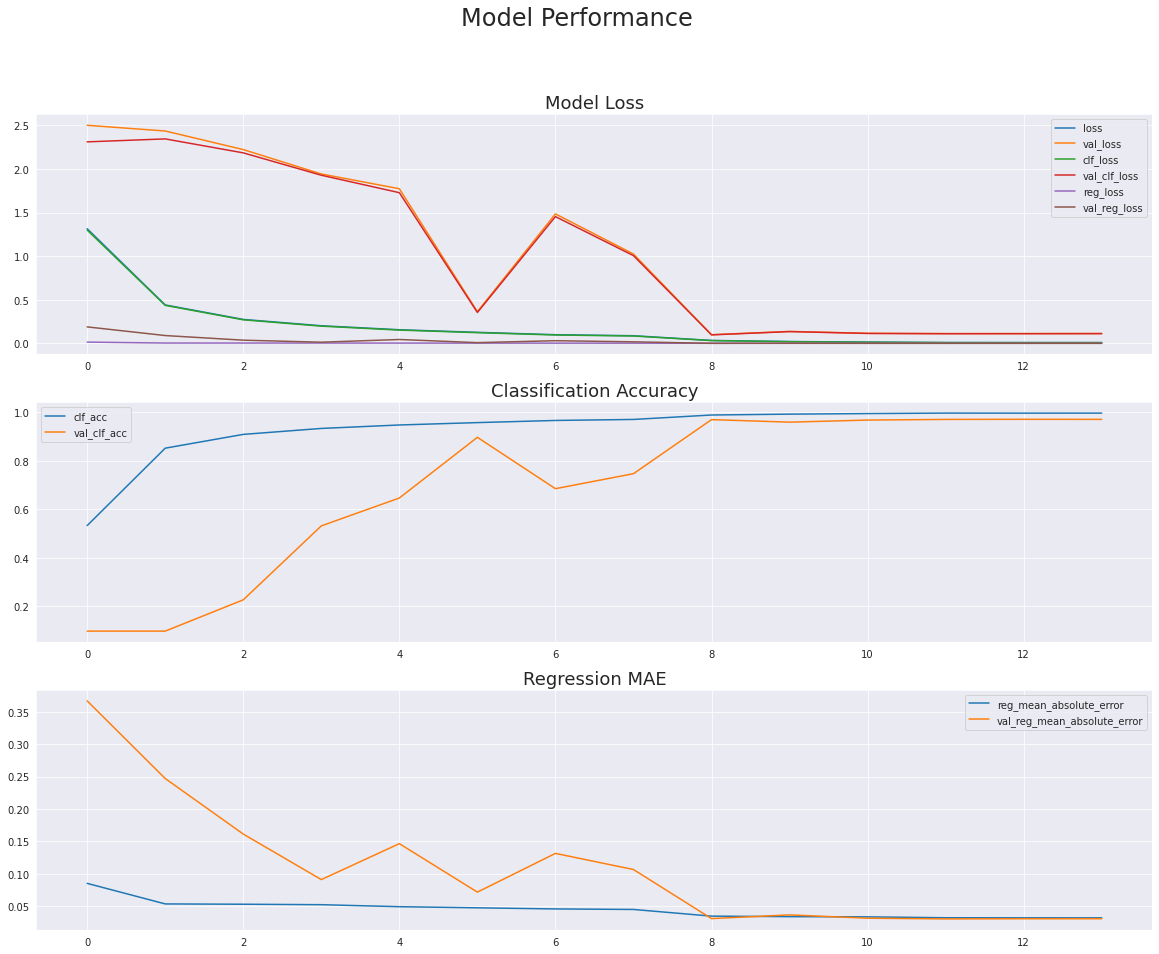

In [10]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
model_metrics = pd.DataFrame(history.history)
model_metrics[['loss', 'val_loss', 'clf_loss', 'val_clf_loss', 'reg_loss', 'val_reg_loss']].plot(ax=ax[0])
model_metrics[['clf_acc', 'val_clf_acc']].plot(ax=ax[1])
model_metrics[['reg_mean_absolute_error', 'val_reg_mean_absolute_error']].plot(ax=ax[2])
ax[0].set_title('Model Loss', fontsize=18)
ax[1].set_title('Classification Accuracy', fontsize=18)
ax[2].set_title('Regression MAE', fontsize=18)
fig.suptitle('Model Performance', fontsize=24);

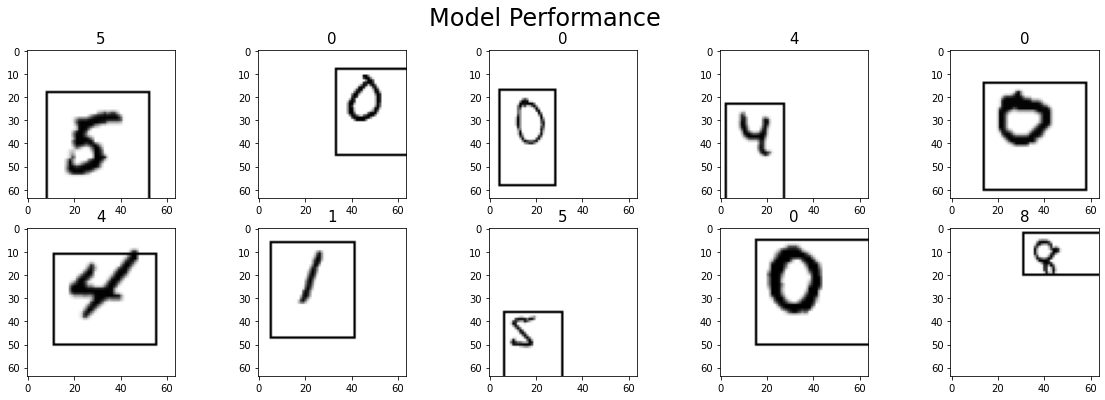

In [11]:
np.random.seed(19)
sns.reset_orig()
Y_pred = model.predict(X)
fig, ax = plt.subplots(2, 5, figsize=(20, 6))
for i, idx in enumerate(np.random.choice(np.arange(70000), size=10)):
    ax[i//5][i%5].imshow(cv2.rectangle(np.squeeze(X[idx].copy()), Y_pred[1][idx]*IMG_SIZE, 0), cmap='gray')
    ax[i//5][i%5].set_title(np.argmax(Y_pred[0][idx]), fontsize=15)
fig.suptitle('Model Performance', fontsize=24);